<a href="https://colab.research.google.com/github/GeoKauko/TheNavySeals/blob/main/2_Seal_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-Net seal detection

In [ ]:
#Connect to the google drive if you use Google Colaboratory
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


## Import libraries

In [31]:
!pip install torch torchvision segmentation-models-pytorch tifffile -q

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import v2 as transforms
import os
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import numpy as np
import tifffile
import torchvision
from PIL import Image
import torch.nn.functional as F
import time

### Define path to tensor files and load train and test data


In [ ]:
# Trying the network with the tree data set https://www.kaggle.com/datasets/earthshot/tree-binary-segmentation?resource=download
# DO NOT RUN WITH SEAL DATA
# DELETE THIS CODE BLOCK ONCE WE HAVE OUR ACTUAL IMAGES

# import torchvision.transforms.functional as TF
# import random

# Change to relative file paths
#train_data_path = "drive/MyDrive/SealNN/Data/Train"
#test_data_path = "drive/MyDrive/SealNN/Data/Test"
# train_data_path = "C:/SealNN/data_test/train"
# test_data_path = "C:/SealNN/data_test/test"


# batch_size = 8  # Can be changed later

# def trans(image, mask):
#     # Resize and grayscale both mask and image
#     resize = transforms.Resize(size=(320, 320))
#     grayscale = transforms.Grayscale(num_output_channels=1)

#     image = resize(image)
#     mask = resize(mask)

#     image = grayscale(image)
#     mask = grayscale(mask)

#     # Random horizontal flipping
#     if random.random() > 0.5:
#         image = TF.hflip(image)
#         mask = TF.hflip(mask)

#     # Random rotation
#     angle = random.uniform(0, 60)  # Random angle between 0 and 60 degrees
#     image = TF.rotate(image, angle)
#     mask = TF.rotate(mask, angle)

#     # Convert to tensor
#     image = TF.to_tensor(image)
#     mask = TF.to_tensor(mask)

#     return image, mask

# # Custom dataset to properly import for segmentation
# def segmentation_dataset(data_path, transform=None):
#     images_path = os.path.join(data_path, "Images")
#     masks_path = os.path.join(data_path, "Masks")
#     image_files = os.listdir(images_path)

#     dataset = []
#     for img_name in image_files:
#         # Read image and corresponding mask using torchvision.io.read_image
#         img_path = os.path.join(images_path, img_name)
#         mask_path = os.path.join(masks_path, img_name.replace(".jpg", ".png"))

#         image = Image.open(img_path)
#         mask = Image.open(mask_path)

#         if transform:
#             mask, image = trans(mask, image)
#             #mask = transform(mask)  # Apply transform to both image and corresponding mask

#         dataset.append((image, mask))  # Append the image-mask pair to the dataset

#     return dataset

# # Create train and test datasets without augmentation
# train_dataset = segmentation_dataset(train_data_path, transform=trans)
# test_dataset = segmentation_dataset(test_data_path, transform=trans)

# # Create train and test data loaders
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # Shuffle on or off?


In [33]:
#Note: code block above still includes data augmentation code, not implemented in this code block (yet)

#train_data_path = "/content/drive/MyDrive/SealNN/Trail_data2/train" #TODO: change to relative file path
#val_data_path = "/content/drive/MyDrive/SealNN/Trail_data2/val"
#test_data_path = "/content/drive/MyDrive/SealNN/Trail_data2/test"
train_data_path = 'C:\\SealNN\\data\\train'
val_data_path = 'C:\\SealNN\\data\\test' #TODO: change to correct folder
#test_data_path = 

batch_size = 8 #Can be changed later

#Custom dataset to properly import for segmentation
def segmentation_dataset(data_path, transform=None):
   images_path = os.path.join(data_path, "images")
   masks_path = os.path.join(data_path, "masks")
   image_files = os.listdir(images_path)

   dataset = []
   for img_name in image_files:
         image = tifffile.imread(os.path.join(images_path, img_name)) #read .tif file
         mask = tifffile.imread(os.path.join(masks_path, img_name[:-4] + '_mask.tif')) #read corresponding mask .tif file

         if transform:
           image = transform(image)
           mask = transform(mask) #apply transform to both image and corresponding mask

         dataset.append((image, mask)) #append the image-mask pair in the dataset

   return dataset

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) #Add more transforms to include e.g. data augmentation

# Create train and test datasets without augmentation
train_dataset = segmentation_dataset(train_data_path, transform=transform)
val_dataset = segmentation_dataset(val_data_path, transform=transform)
#test_dataset = segmentation_dataset(test_data_path, transform=transform)

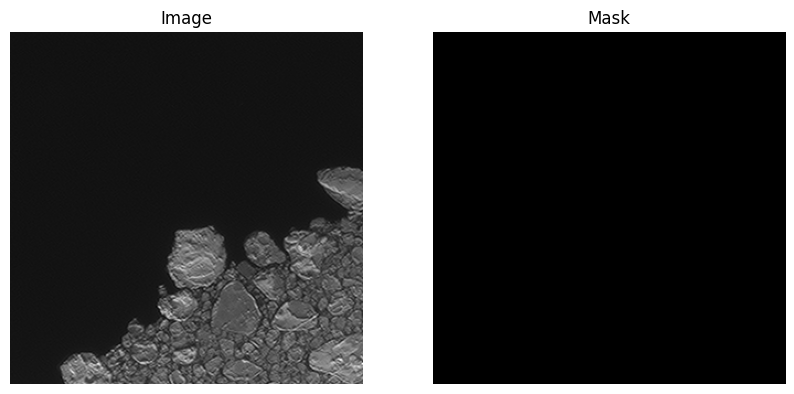

torch.Size([1, 320, 320])
torch.Size([1, 320, 320])


In [34]:
image, mask = train_dataset[160]
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image.permute(1, 2, 0), cmap = 'gray')  # Convert from tensor format (C, H, W) to (H, W, C)
axes[0].set_title('Image')
axes[0].axis('off')
axes[1].imshow(mask.permute(1, 2, 0), cmap = 'gray')  # Convert from tensor format (C, H, W) to (H, W, C)
axes[1].set_title('Mask')
axes[1].axis('off')
plt.show()

print(image.shape)
print(mask.shape)

In [40]:
#Check which indices contain seals for train and test set

train_dataset_seals = []
background_number_train = 249
background_number_test = 89

for i in range(0, len(train_dataset)):
    image, mask = train_dataset[i]
    mean_image = image.float().mean().item()
    mean_mask = mask.float().mean().item()
    if (mean_mask > 0):
        train_dataset_seals.append(train_dataset[i])
    elif (background_number_train != 0) and (mean_image > 250):
        train_dataset_seals.append(train_dataset[i])
        background_number_train -= 1

val_dataset_seals = []
for i in range(0, len(val_dataset)):
    image, mask = val_dataset[i]
    mean_image = image.float().mean().item()
    mean_mask = mask.float().mean().item()
    if (mean_mask > 0):
        val_dataset_seals.append(val_dataset[i])
    elif (background_number_test != 0) and (mean_image > 250):
        val_dataset_seals.append(val_dataset[i])
        background_number_test -= 1


# Create train and test data loaders
train_loader = torch.utils.data.DataLoader(train_dataset_seals, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset_seals, batch_size=batch_size, shuffle=True)
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False) #Shuffle on or off?

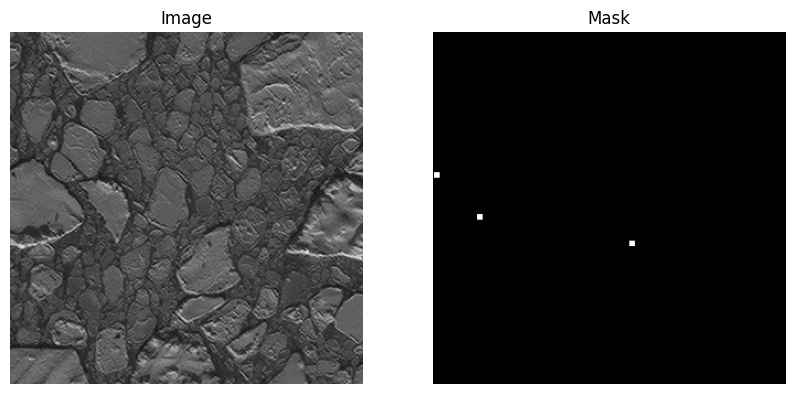

torch.Size([1, 320, 320])
torch.Size([1, 320, 320])


In [42]:
image, mask = train_dataset_seals[450]
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image.permute(1, 2, 0), cmap = 'gray')  # Convert from tensor format (C, H, W) to (H, W, C)
axes[0].set_title('Image')
axes[0].axis('off')
axes[1].imshow(mask.permute(1, 2, 0), cmap = 'gray')  # Convert from tensor format (C, H, W) to (H, W, C)
axes[1].set_title('Mask')
axes[1].axis('off')
plt.show()

print(image.shape)
print(mask.shape)

#### Check GPU

In [43]:
#check the GPU colab assigns to you
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Jun 17 14:20:08 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.78                 Driver Version: 551.78         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1050      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   54C    P8             N/A /   14W |    3121MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Define the model (U-Net)

In [54]:
#source:https://smp.readthedocs.io/en/latest/models.html#unet
model = smp.Unet(
    encoder_name="efficientnet-b1", # choose encoder, e.g. mobilenet_v2 or efficientnet-b7 we chose efficientnet-b1 based on the SealNet 2.0
    encoder_weights=None, # we do not have a pretrained model, so we put none and the model will use random weigths
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1 # model output channels (number of classes in your dataset)

)
#model.segmentation_head[2] = nn.Sigmoid()

### Training and testing

Epoch 1/1, Train Loss: 0.2344, Val Loss: 0.3833, Epoch time:  65.12s, LR: 0.001
Epoch 1/1, Train Accuracy: 99.8724%, Val Accuracy: 99.9010% 



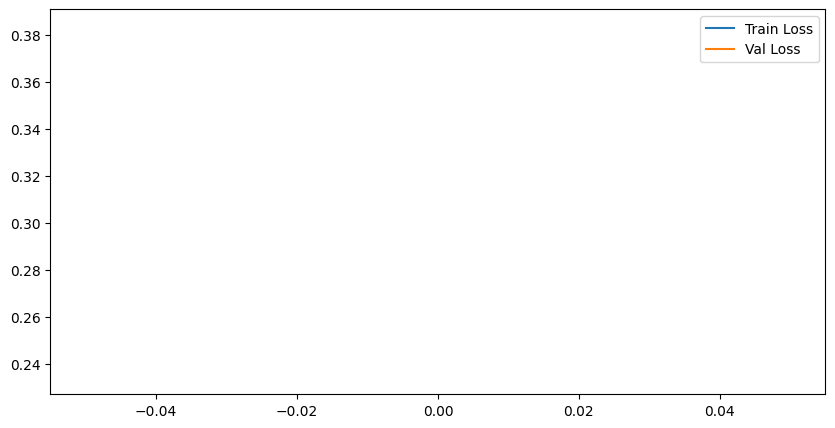

In [58]:
learning_rate = 0.001
num_epochs = 1
# Define the loss function and optimizer
# Tversky loss https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch
alpha = 0.1
beta = 0.9


# Function for defining accuracy

def accuracy(all_outputs, all_masks, threshold = 0.5):

    all_outputs = torch.cat(all_outputs, dim = 0)
    all_masks= torch.cat(all_masks, dim = 0)

    pred = (all_outputs > threshold).float()
    cor_pred = (pred == all_masks).float().sum()

    total_pred = all_masks.numel()
    accuracy = (cor_pred/total_pred)*100

    return(accuracy.item())

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

class TverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(TverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=alpha, beta=beta):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()

        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)

        return 1 - Tversky



# What loss function do we want
criterion = TverskyLoss()
#criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy loss with logits

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

# Training and validation loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []

tr_accs = []
val_accs = []
for epoch in range(num_epochs):
    start_time = time.time() #start time for epoch
    
    model.train()
    train_loss = 0.0
    tr_all_outputs = []
    tr_all_masks = []
    for image, mask in train_loader:
        image, mask = image.to(device, dtype=torch.float), mask.to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, mask) #mask.float() maybe?
        loss.backward()
        optimizer.step()
        outputs = torch.sigmoid(outputs)
        outputs= outputs.cpu().detach()
        tr_all_outputs.append(outputs)
        tr_all_masks.append(mask.cpu().detach())
        train_loss += loss.item()

    tr_acc = accuracy(tr_all_outputs, tr_all_masks)
    tr_accs.append(tr_acc)

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    val_all_outputs = []
    val_all_masks = []
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device, dtype=torch.float), mask.to(device, dtype=torch.float)
            outputs = model(image)
            loss = criterion(outputs, mask) #mask.float() maybe?
            outputs = torch.sigmoid(outputs)
            outputs= outputs.cpu().detach()
            val_all_outputs.append(outputs)
            val_all_masks.append(mask.cpu().detach())
            val_loss += loss.item()

    val_acc = accuracy(val_all_outputs, val_all_masks)
    val_accs.append(val_acc)

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    scheduler.step()
    
    end_time = time.time()
    epoch_time = end_time - start_time
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Epoch time: {epoch_time: .2f}s, LR: {get_lr(optimizer)}')
    print(f'Epoch {epoch+1}/{num_epochs}, Train Accuracy: {tr_acc:.4f}%, Val Accuracy: {val_acc:.4f}% \n')

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()

99.87236785888672


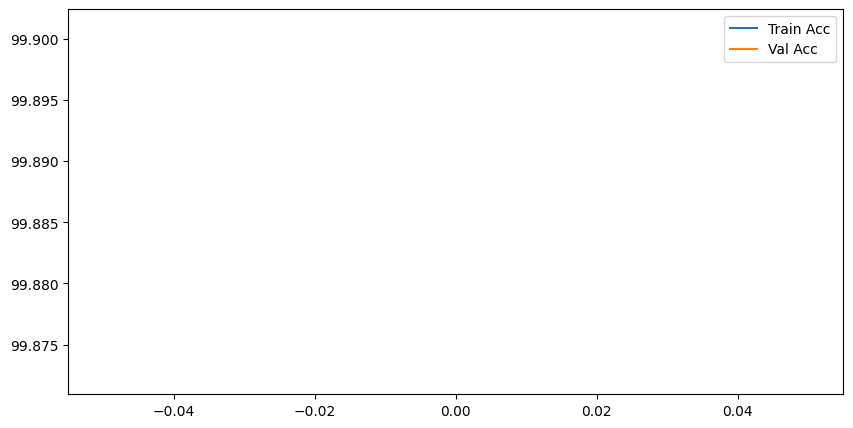

In [59]:
print(tr_acc)

plt.figure(figsize=(10, 5))
plt.plot(tr_accs, label='Train Acc')
plt.plot(val_accs, label = "Val Acc")
#plt.ylim(99.9, 100.1)
plt.legend()
plt.show()

## Test accuracy and precision/recall curve

precision = how many of the ground truth instances are found?
recall = how many of the predicted instances are correct?

Test Accuracy: 100.0%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


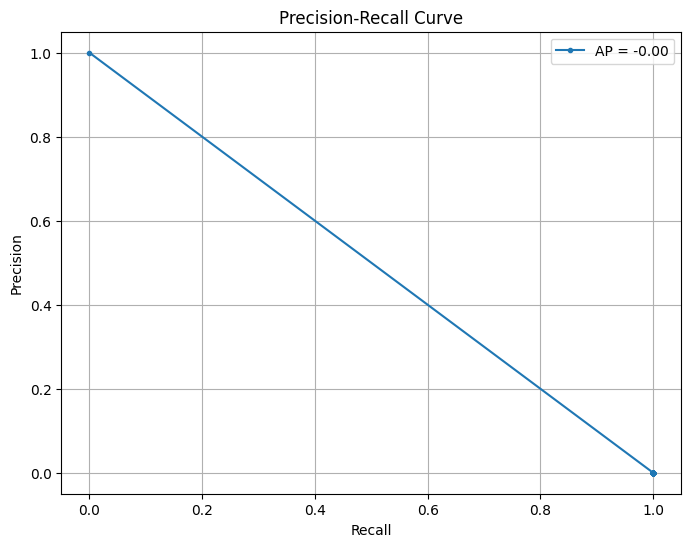

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Evaluate the model and collect outputs and masks
model.eval()

te_all_outputs = []
te_all_masks = []

for image, mask in test_loader:
    image, mask = image.to(device, dtype=torch.float), mask.to(device, dtype=torch.float)
    outputs = model(image)

    outputs = torch.sigmoid(outputs)  # Assuming the output is a logit
    outputs = outputs.cpu().detach()

    te_all_outputs.append(outputs)
    te_all_masks.append(mask.cpu().detach())

te_accuracy = accuracy(te_all_outputs, te_all_masks)

print(f'Test Accuracy: {te_accuracy}%')

# Create precision and recall curve
# Concatenate all outputs and masks to match the dataset size
all_outputs_pr = all_outputs_acc.numpy().flatten()
all_masks_pr = all_masks_acc.numpy().flatten()

# Compute precision-recall pairs
precision, recall, thresholds = precision_recall_curve(all_masks_pr, all_outputs_pr)
average_precision = average_precision_score(all_masks_pr, all_outputs_pr)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'AP = {average_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


# Prediction visualisation


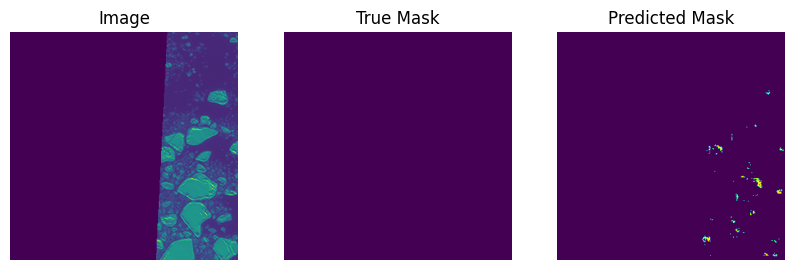

In [ ]:
#for i in range(len(outputs[:2])):
i = 19

# Set visualization variables
image, mask = test_dataset[i]
pred = all_outputs_acc[i]
#pred = (pred).round_()
#print(pred)
pred_print = (pred > 0.8).float()
#print(pred_print)
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

# Show image on axis 0
axes[0].imshow(image.permute(1, 2, 0))  # Convert from tensor format (C, H, W) to (H, W, C)
axes[0].set_title('Image')
axes[0].axis('off')

# Show True mask on axis 1
axes[1].imshow(mask.permute(1, 2, 0))  # Convert from tensor format (C, H, W) to (H, W, C)
axes[1].set_title('True Mask')
axes[1].axis('off')

pred_print_np = pred_print.squeeze().cpu().numpy()
axes[2].imshow(pred_print_np)  # Use grayscale colormap for binary mask
axes[2].set_title('Predicted Mask')
axes[2].axis('off')

plt.show()

### Define model again, but with Imagenet weights and transforms

In [ ]:
#source:https://smp.readthedocs.io/en/latest/models.html#unet
# model = smp.Unet(
#     encoder_name="efficientnet-b6", # choose encoder, e.g. mobilenet_v2 or efficientnet-b7 we chose efficientnet-b1 based on the SealNet 2.0
#     encoder_weights=None, # we do not have a pretrained model, so we put none and the model will use random weigths
#     in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#     classes=1 # model output channels (number of classes in your dataset)
# )

In [ ]:
# learning_rate = 0.00001
# num_epochs = 2

# # Define the loss function and optimizer
# # Tversky loss https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch
# ALPHA = 0.5
# BETA = 0.8

# class TverskyLoss(nn.Module):
#     def __init__(self, weight=None, size_average=True):
#         super(TverskyLoss, self).__init__()

#     def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA):

#         #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = F.sigmoid(inputs)

#         #flatten label and prediction tensors
#         inputs = inputs.view(-1)
#         targets = targets.view(-1)

#         #True Positives, False Positives & False Negatives
#         TP = (inputs * targets).sum()
#         FP = ((1-targets) * inputs).sum()
#         FN = (targets * (1-inputs)).sum()

#         Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)

#         return 1 - Tversky



# # What loss function do we want
# #criterion = TverskyLoss()
# criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy loss with logits

# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# # Training and validation loop
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# train_losses = []
# test_losses = []

# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0.0
#     for image, mask in train_loader:
#         image, mask = image.to(device, dtype=torch.float), mask.to(device, dtype=torch.float)

#         optimizer.zero_grad()
#         outputs = model(image)
#         loss = criterion(outputs, mask) #mask.float() maybe?
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item()

#     train_loss /= len(train_loader)
#     train_losses.append(train_loss)

#     model.eval()
#     test_loss = 0.0
#     with torch.no_grad():
#         for image, mask in test_loader:
#             image, mask = image.to(device, dtype=torch.float), mask.to(device, dtype=torch.float)
#             outputs = model(image)
#             loss = criterion(outputs, mask) #mask.float() maybe?
#             test_loss += loss.item()

#     test_loss /= len(test_loader)
#     test_losses.append(test_loss)

#     print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

# # Plot training and validation loss
# plt.figure(figsize=(10, 5))
# plt.plot(train_losses, label='Train Loss')
# plt.plot(test_losses, label='Test Loss')
# plt.legend()
# plt.show()

In [ ]:
# model.eval()

# # Run the model on the test data
# all_outputs = []

# for image, mask in test_loader:
#     image, mask = image.to(device, dtype=torch.float), mask.to(device, dtype=torch.float)
#     outputs = model(image)
#     outputs = torch.sigmoid(outputs)  # Assuming the output is a logit
#     outputs = outputs.cpu().detach()
#     all_outputs.append(outputs)

# # Concatenate all outputs to match the dataset size
# all_outputs = torch.cat(all_outputs, dim=0)

In [ ]:
# for i in range(len(outputs[:2])):

#   # Set visualization variables
#   image, mask = test_dataset_seals[i]
#   pred = all_outputs[i]
#   #pred = (pred).round_()
#   pred = (pred > 0.5).float()
#   fig, axes = plt.subplots(1, 3, figsize=(10, 5))

#   # Show image on axis 0
#   axes[0].imshow(image.permute(1, 2, 0))  # Convert from tensor format (C, H, W) to (H, W, C)
#   axes[0].set_title('Image')
#   axes[0].axis('off')

#   # Show True mask on axis 1
#   axes[1].imshow(mask.permute(1, 2, 0))  # Convert from tensor format (C, H, W) to (H, W, C)
#   axes[1].set_title('True Mask')
#   axes[1].axis('off')

#   # Show predicted mask on axis 2
#   axes[2].imshow(pred.permute(1,2,0))
#   axes[2].set_title('Predicted Mask')
#   axes[2].axis('off')

#   plt.show()

In [ ]:
#alter datasets
# Create train and test datasets for imagenet
# TODO implement Kee's code for transformations + make the entire thing RGB

# transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# train_dataset = segmentation_dataset(train_data_path, transform=transform)
# test_dataset = segmentation_dataset(test_data_path, transform=transform)